<h1><center><font size="6">Post-Augmentation Modeling Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>Augmentations through ImageDataGenerator</a>
- <a href='#3'>Augmentations through Albumentations</a> 
- <a href='#4'>CNN Model</a>
- <a href='#5'>Final CNN Model</a>
    - <a href='#51'>Generate Datasets</a>   
    - <a href='#52'>Constructing the Model</a>   
    - <a href='#53'>Compiling the Model</a>   
    - <a href='#54'>Defining Callbacks</a>   
    - <a href='#55'>Training the Model</a>   
    - <a href='#56'>Evaluating the Model</a>
    - <a href='#57'>Save Model</a>    
    - <a href='#58'>Predicting on Testing Set</a>  


# Importing Packages

In [8]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from utils import *

%reload_ext autoreload
%autoreload 2


# Augmentation through ImageDataGenerator

In [9]:
# generating augmentations through ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

# assigning paths
train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

# generating datasets for training, validation, and testing
train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
# create model
model = create_model((224, 224, 3))
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [82]:
# define callbacks
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# train model
history = model.fit_generator(generator = train_generator,
                             epochs = 20,
                             steps_per_epoch = len(train_generator),
                             callbacks = [earlyStopping, mcp_save],
                             validation_data = val_generator)

# Augmentation through Albumentations

I chose to create the augmentations/transformations of each melanoma image in the training folder using the Albumentations module and place the augmentations into a folder within the melanoma subfolder of the training image dataaset folder.

In [4]:
# create datasets for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [5]:
X_tr, y_tr = next(train_generator)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

# CNN Model

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics in my initial development of different models and hence able to differentiate between the minority and majority class.

In [36]:
# build model similar to VGG16
def cnn_model_1(input_shape):
    return Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Flatten(),
        Dense(units=4096, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])

model2 = cnn_model_1((256, 256, 3))

In [37]:
# Compile Model
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve = 'PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [38]:
# Define callbacks
filepath = '../models/cnn_model_1.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')

# train model
history2 = model2.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, earlyStopping],
                     validation_data = valid_generator)

NameError: name 'val_generator' is not defined

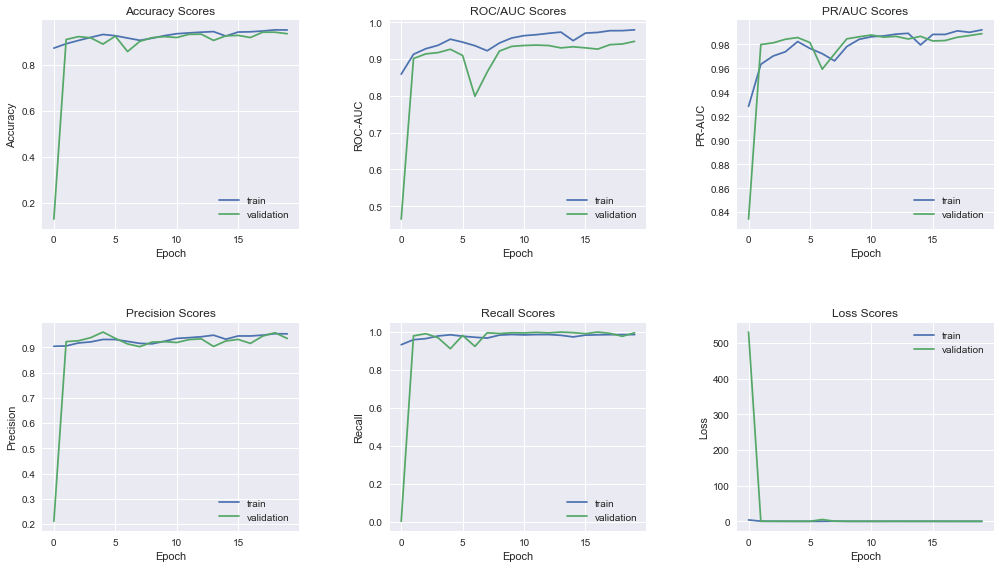

In [8]:
# evaluate model by displaying metrics with visualization
plt.style.use('seaborn')
sixplot(history2, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [31]:
# display metrics in dataframe
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall
0,4.088655,0.873538,0.858984,0.928289,0.904718,0.932002,530.170166,0.128154,0.465127,0.834200,0.210526,0.003072
1,0.585988,0.892544,0.913018,0.963356,0.905938,0.958317,0.254490,0.911023,0.901481,0.979847,0.923188,0.978495
2,0.395820,0.906871,0.928162,0.970257,0.917871,0.963888,0.265129,0.923639,0.914138,0.981249,0.926671,0.990015
3,0.282272,0.920322,0.937444,0.973830,0.922116,0.977910,0.226879,0.918327,0.917617,0.984241,0.938943,0.968510
4,0.192176,0.933041,0.954082,0.982336,0.931793,0.984057,0.270012,0.891102,0.926745,0.985684,0.961102,0.910906
5,0.221897,0.927485,0.946041,0.976601,0.931477,0.976565,0.235522,0.925631,0.909807,0.981466,0.936217,0.980799
6,0.320801,0.917398,0.936383,0.972220,0.924146,0.971187,5.254061,0.858566,0.798910,0.959308,0.914068,0.923195
7,0.823735,0.907456,0.922623,0.966210,0.916257,0.966769,0.453580,0.903054,0.864759,0.972119,0.903068,0.994624
8,0.245090,0.916667,0.943743,0.978159,0.914373,0.982520,0.235961,0.918991,0.921907,0.984599,0.921429,0.990783
9,0.190809,0.927778,0.957329,0.984174,0.924505,0.985594,0.200266,0.923639,0.934575,0.986305,0.923022,0.994624


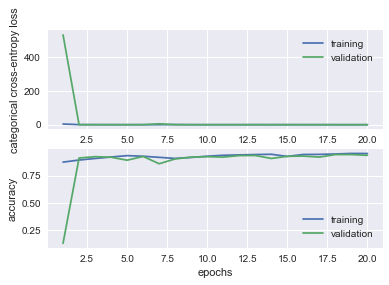

In [32]:
# visualization for loss and accuracy
train_val_metrics(20, history2)

In [39]:
# get testing loss and accuracy
score = model2.evaluate(X_tt, y_tt, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

7/7 [==============================] - 24s 3s/step - loss: 2.2692 - accuracy: 0.4299 - auc: 0.5457 - auc_1: 0.7858 - precision: 0.7733 - recall: 0.3558
loss: 2.269223213195801
accuracy: 0.42990654706954956


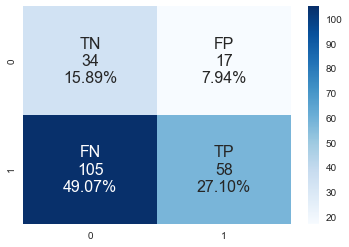

In [35]:
# confusion matrix
prob = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5
make_confusion_matrix(y_true, y_pred2)

# Final CNN Model

Most of these changes occurred after my capstone presentation at the end of the course.  I started doing some online courses delving into deep learning and convolutional neural networks to start having an understanding of what I was really doing.  As the sole cohort member tackling neural networks in regards to image classification, I relied on my advisor, who completed his capstone on old photo restoration using GANs, for any feedback or advice, and even then, there wasn't always overlap between his knowledge or experience and what I needed advice on.  3 weeks was insufficient time at least for me to tackle such a daunting subject as well as such an unwieldy dataset.  Admittedly the underlying motivation for a lot of decisions in developing a model was minimizing the time for training, but completing my project post-course allowed me to learn more about how to tune the different hyperparameters and play with different aspects of neural networks. 

In the previous model, each epoch was taking over an hour to complete even with the smaller sample size, and it proved very unmanageable to run the model multiple times.  This final model was motivated in the interest of minimizing the amount of time in training the model even with the smaller sample size and after receiving some feedback from a data scientist friend to use just one convolutional layer.  So removing one of the convolutional layers from each....and adding Dropout layers, lowering batch size to 16 shaved off a substantial amount of time in my training process.

For any future Flatiron or data science students learning about neural networks from scratch, here are some of the insights I have gained through reading or from my project advisor:
- For test_generator, shuffle must be set to False, and batch size should be set to 1 in order for the step size equal to the length of test dataset.  What I mean is that the batch size should be the length of the dataset, but using the formula of length (n) divided by batch size for training and validation would mean batch size for testing is 1.
- Images must be normalized with `rescale=1./255)`
- Different models will require different input size.
- My advisor suggested I use Adam as optimizer from the get go.  I started at a learning rate of 0.01, and at a later point, my advisor suggested lowering it to 0.001 to get better results.  I was looking at some models which then incorporated the callback of the learning rate scheduler, so I incorporated that into the model.

To be continued...I will continue to add more insights as well as the reasoning behind each.

## Generate Datasets

In [3]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## Constructing the Model

In [4]:
# construct model
def cnn2(input_shape):
    return Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2), 
        MaxPool2D(pool_size=(3, 3)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dropout(0.25),     
        Dense(units=1, activation='sigmoid')
        ])

model3 = cnn2((256, 256, 3))

## Compiling the Model

In [5]:
# compile model
model3.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

## Defining Callbacks

In [19]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
# earlyStopping = EarlyStopping(monitor = 'val_loss', 
#                               verbose = 1, 
#                               mode = 'min', 
#                               patience = 4)
filepath = "../logs/log_cnn2/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_cnn2/log.csv')
log_dir = "../logs/log_cnn2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## Training the Model

In [20]:
# train model
history3 = model3.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 2147s 5s/step - loss: 0.1309 - accuracy: 0.9515 - auc: 0.9786 - auc_1: 0.9909 - precision: 0.9522 - recall: 0.9857 - val_loss: 0.2937 - val_accuracy: 0.9415 - val_auc: 0.9102 - val_auc_1: 0.9772 - val_precision: 0.9366 - val_recall: 1.0000

Epoch 00001: saving model to ../logs/log_cnn2/model.01-0.29.hdf5
Epoch 2/20
427/427 [==============================] - 2145s 5s/step - loss: 0.1311 - accuracy: 0.9557 - auc: 0.9781 - auc_1: 0.9902 - precision: 0.9552 - recall: 0.9883 - val_loss: 0.3307 - val_accuracy: 0.9481 - val_auc: 0.9347 - val_auc_1: 0.9872 - val_precision: 0.9580 - val_recall: 0.9831

Epoch 00002: saving model to ../logs/log_cnn2/model.02-0.33.hdf5
Epoch 3/20
427/427 [==============================] - 2179s 5s/step - loss: 0.1220 - accuracy: 0.9576 - auc: 0.9810 - auc_1: 0.9915 - precision: 0.9564 - recall: 0.9894 - val_loss: 0.2877 - val_accuracy: 0.9309 - val_auc: 0.9415 - val_auc_1: 0.9869 - val_precision: 0.9517 - val_r

## Evaluating the Model

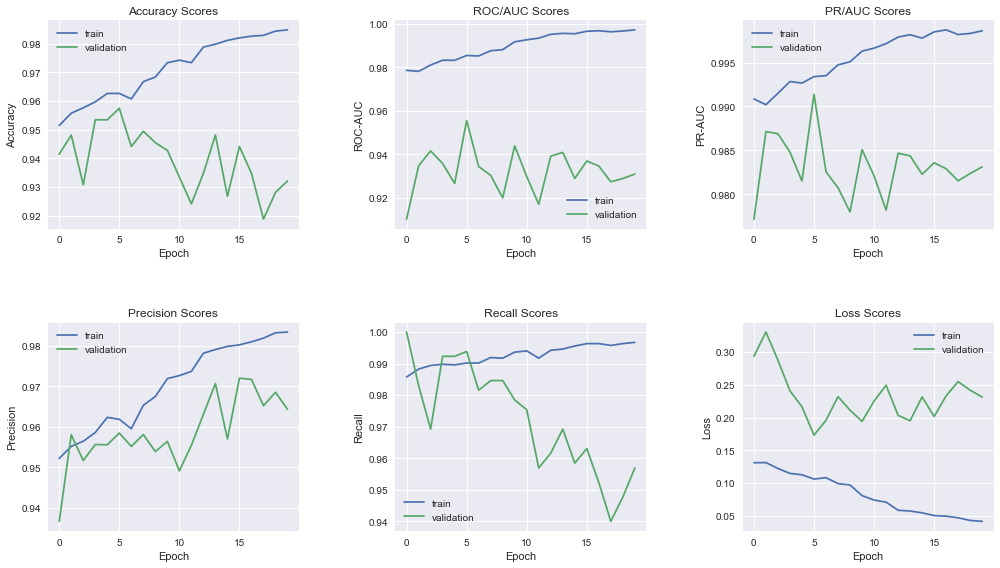

In [21]:
# create visualization of metrics
plt.style.use('seaborn')
sixplot(history3, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [22]:
# create dataframe of metrics
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall,lr
0,0.130871,0.951495,0.978567,0.990859,0.952186,0.985747,0.293684,0.941489,0.910189,0.977197,0.936599,1.000000,0.001000
1,0.131070,0.955744,0.978112,0.990203,0.955163,0.988258,0.330746,0.948138,0.934668,0.987154,0.958021,0.983077,0.001000
2,0.122031,0.957649,0.981006,0.991503,0.956425,0.989405,0.287677,0.930851,0.941538,0.986908,0.951662,0.969231,0.001000
3,0.114582,0.959701,0.983225,0.992838,0.958598,0.989794,0.240846,0.953457,0.935750,0.984812,0.955621,0.992320,0.001000
4,0.112415,0.962632,0.983180,0.992664,0.962345,0.989597,0.216395,0.953457,0.926584,0.981533,0.955556,0.992308,0.001000
5,0.105909,0.962632,0.985399,0.993392,0.961862,0.990185,0.172995,0.957447,0.955505,0.991395,0.958457,0.993846,0.001000
6,0.107915,0.960727,0.985179,0.993505,0.959530,0.990185,0.195817,0.944149,0.934358,0.982579,0.955157,0.981567,0.001000
7,0.098933,0.966735,0.987564,0.994733,0.965343,0.991915,0.231918,0.949468,0.930309,0.980771,0.958084,0.984615,0.001000
8,0.096778,0.968347,0.988094,0.995081,0.967512,0.991723,0.211299,0.945479,0.919956,0.978011,0.953869,0.984639,0.001000
9,0.080546,0.973329,0.991685,0.996287,0.971929,0.993644,0.194074,0.942819,0.943854,0.985096,0.956391,0.978462,0.000500


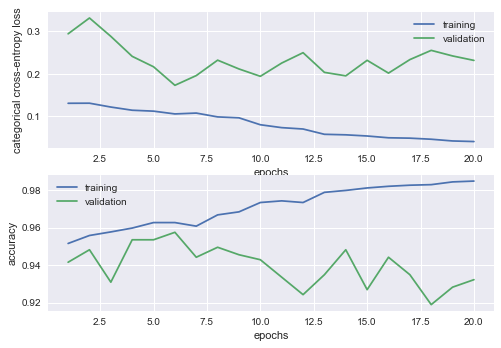

In [23]:
# plot accuracy and loss
plt.style.use('seaborn')
train_val_metrics(20, history3)

## Save Model

In [24]:
model3.save('../models/cnn_final')

INFO:tensorflow:Assets written to: ../models/cnn_final/assets


In [ ]:
model3.save('../models/cnn_final.h5')

## Predicting on Testing Set

In [ ]:
test_generator.reset()
pred = model.predict_generator(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose = 1)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [26]:
test_generator.reset()
prob3 = model3.predict_generator(test_generator,
                                 steps = STEP_SIZE_TEST,
                                 verbose = 1)

753/753 [==============================] - 128s 170ms/step


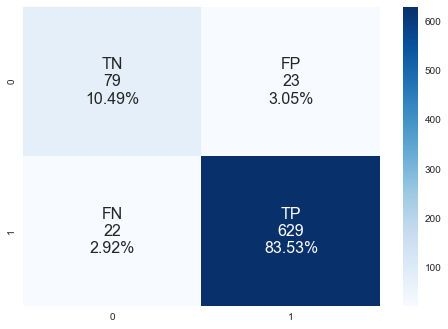

In [27]:
y_true = test_generator.classes
y_pred_3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred_3)

In [31]:
# get testing accuracy and loss
score = model3.evaluate_generator(test_generator, verbose = 1)
labels = model3.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

753/753 [==============================] - 124s 164ms/step - loss: 0.1862 - accuracy: 0.9402 - auc: 0.9380 - auc_1: 0.9857 - precision: 0.9647 - recall: 0.9662
loss: 0.18618255853652954
accuracy: 0.9402390718460083


# Analysis

The final CNN model is able not only to differentiate between the two classes, but is able to achieve high metrics across the board in terms of ROC-AUC and PR-AUC scores.